In [ ]:
!pip install roboflow

In [1]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key=os.environ["ROBOFLOW_TOKEN"])
project = rf.workspace("thesis-kztn8").project("littering-whlsk")
version = project.version(8)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Littering--8 in yolov11:: 100%|███████| 34812/34812 [07:36<00:00, 76.29it/s]


In [12]:
import os
SCRIPT_DIR = os.path.abspath("")

## Processing sequential frames

In [13]:
dataset_dir = os.path.join(SCRIPT_DIR, 'kkpm.v1-raw.yolov11')

In [14]:
import pickle 

pkl_file = os.path.join(dataset_dir, 'file_sequences.pkl')

with open(pkl_file, 'rb') as f:
  file_sequences = pickle.load(f)

len(file_sequences)

330

In [15]:
video_dir = os.path.join(dataset_dir, 'train/images')
files = [[(os.path.join(video_dir, file), file) for file in sequence] for sequence in file_sequences]

In [20]:
from ultralytics import YOLO
from tqdm import tqdm
from IPython.display import clear_output

# Load a model
model = YOLO(os.path.join(SCRIPT_DIR, "model/TrashDetectorv2/weights/last.pt"))
inf_files = [f for sub in files for f in sub]

# Process results generator
for i in tqdm(range(len(inf_files))):
    file = inf_files[i][0]
    result = model(file)[0]
    boxes = result.boxes 
    masks = result.masks 
    keypoints = result.keypoints 
    probs = result.probs 
    obb = result.obb 
    f = os.path.join(SCRIPT_DIR,f"yolo_res/images_train/{inf_files[i][1]}")
    f_text = os.path.join(SCRIPT_DIR,f"yolo_res/label_train/{inf_files[i][1].replace(".jpg", ".txt")}")
    # print(f)
    result.save(filename=f)
    result.save_txt(txt_file=f_text)
    clear_output()

100%|██████████████████████████| 9899/9899 [38:31<00:00,  4.28it/s]


## Segmenting Region Proposal

In [5]:
from classifier import segment
from tqdm import tqdm
from IPython.display import clear_output

out = os.path.join(SCRIPT_DIR, 'segmented')

for i in tqdm(range(len(file_sequences))):
    for j in range(len(file_sequences[i])):
        label = os.path.join(SCRIPT_DIR, f"yolo_res/label_train/{file_sequences[i][j].replace(".jpg",".txt")}")
        img = os.path.join(SCRIPT_DIR, f"kkpm.v1-raw.yolov11/train/images/{file_sequences[i][j]}")
        segment.crop_humans(img, file_sequences[i][j], label,out)
    clear_output()


100%|████████████████████████████| 330/330 [23:42<00:00,  4.31s/it]


## Extracting Pose Objects

In [1]:
!pip install -q mediapipe

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [34]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pose_util import pose_util
import csv

out_dir = os.path.join(SCRIPT_DIR, 'landmarks')
segmented_dir = os.path.join(SCRIPT_DIR, 'segmented')

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


for i in tqdm(range(68, len(file_sequences))):
    sequence = file_sequences[i]
    csv_out = []
    for j, filename in enumerate(sequence):
        inp = os.path.join(segmented_dir, filename.replace(".jpg",""))
        if not os.path.exists(inp):
            continue
        jpg_files = [f for f in os.listdir(inp) if f.lower().endswith('.jpg')]
        for file in jpg_files:
            img_path = os.path.join(inp, file)
            image = mp.Image.create_from_file(img_path)
            detection_result = detector.detect(image)
            person_dict = {'sequence_id': i, 'frame_id': j, 
                           'file_name': filename, 
                           'unproc_person_id': file,
                          }
            pose_landmark_list = detection_result.pose_landmarks
            pose_landmark = pose_landmark_list[0] if len(pose_landmark_list) > 0 else None
            if pose_landmark is None:
                continue
            for k, landmark in enumerate(pose_landmark):
                person_dict[f'landmark_x_{k}'] = landmark.x
                person_dict[f'landmark_y_{k}'] = landmark.y
                person_dict[f'landmark_z_{k}'] = landmark.z
                person_dict[f'visibility_{k}'] = landmark.visibility
                person_dict[f'presence_{k}'] = landmark.presence
            csv_out.append(person_dict)
    csv_file = os.path.join(out_dir, f"sequence_{i}.csv")
    if len(csv_out) > 0:
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=csv_out[0].keys())
            writer.writeheader()
            writer.writerows(csv_out)

I0000 00:00:1733042766.958524  563491 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733042766.993393  601299 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1733042767.056991  601301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733042767.151095  601311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|███████████████████████████| 262/262 [37:18<00:00,  8.54s/it]


## Augment CSV with global features

In [ ]:
from classifier import feature_extractor
from tqdm import tqdm
from IPython.display import clear_output

csv_dir = os.path.join(SCRIPT_DIR, 'landmarks')

for i in tqdm(range(0, len(file_sequences))):
    csv_file = os.path.join(csv_dir, f"sequence_{i}.csv")
    label_gt_dir = os.path.join(SCRIPT_DIR, 'kkpm.v1-raw.yolov11/train/labels')
    label_yolo_dir = os.path.join(SCRIPT_DIR, 'yolo_res/label_train')
    feature_extractor.extract_global_features(label_gt_dir=label_gt_dir, label_yolo_dir=label_yolo_dir, csv_file=csv_file)
    clear_output()

## Fill in Missing Frames

In [19]:
csv_dir = os.path.join(SCRIPT_DIR, 'landmarks')
csv_file_path = os.path.join(csv_dir, f"sequences.csv")
label_yolo_dir = os.path.join(SCRIPT_DIR, 'yolo_res/label_train')

import csv

def query_csv(reader, sequence_value, frame_id_value, unproc_person_id):
    results = []
    for row in reader:
        if int(row['sequence_id']) == sequence_value and int(row['frame_id']) == frame_id_value and unproc_person_id:
            results.append(row)
    return results


# Prepare to append rows
with open(csv_file_path, mode='r+', newline='') as csv_file:
    # Infer fieldnames from the existing file
    try:
        reader = csv.DictReader(csv_file)
        fieldnames = reader.fieldnames
        if not fieldnames:
            raise ValueError("No fieldnames in existing file.")
    except (FileNotFoundError, ValueError):
        # File doesn't exist or has no headers; fallback to defaults
        fieldnames = [
            'sequence_id', 'frame_id', 'file_name', 'unproc_person_id',
            'person_x', 'person_y', 'person_w', 'person_h'
        ]

    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    # Append new rows
    for i in tqdm(range(0, len(file_sequences))):
        for j in range(len(file_sequences[i])):
            label_file_name = file_sequences[i][j].replace(".jpg", ".txt")
            file_exists = os.path.exists(os.path.join(label_yolo_dir, label_file_name))
            if file_exists:
                with open(os.path.join(label_yolo_dir, label_file_name)) as label_file:
                    lines_label = [line.strip() for line in label_file]
                    for k, line in enumerate(lines_label):
                        if line.split()[0] == '0':  # Check condition for label type
                            res = query_csv(reader, i, j, k)
                            if len(res) < 1:  # If not already in CSV
                                new_row = {
                                    'sequence_id': i,
                                    'frame_id': j,
                                    'file_name': file_sequences[i][j],
                                    'unproc_person_id': f"{k}.jpg",
                                    'person_x': float(line.split()[1]),
                                    'person_y': float(line.split()[2]),
                                    'person_w': float(line.split()[3]),
                                    'person_h': float(line.split()[4]),
                                }
                                for key in fieldnames:
                                    new_row.setdefault(key, None)
                                
                                writer.writerow(new_row)



100%|█████████████████████████████| 330/330 [03:21<00:00,  1.64it/s]


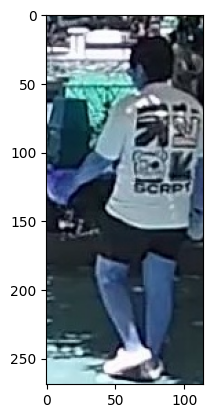

In [6]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

i = 272
img_path = "/mnt/c/Adrianov/Projects/trash-detector/segmented/video_8_1_jpg.rf.e0344bb2cbcf64e3b4dc9575fe6c5fc6/0.jpg"
img = cv2.imread(img_path)
# print(img_path)
# print(img)
plt.imshow(img)
plt.show()

In [11]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pose_util import pose_util

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
# image = mp.Image.create_from_file(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

test = ['video_8_1_jpg.rf.e0344bb2cbcf64e3b4dc9575fe6c5fc6.jpg',
 'video_8_2_jpg.rf.5a3199296a8b49faa5306376d3630626.jpg',
 'video_8_3_jpg.rf.1d9fdddc019ad19131ea8195908b8034.jpg',
 'video_8_4_jpg.rf.a1f187a5d6af8029a91d413ed45a0d6c.jpg',
 'video_8_5_jpg.rf.9769894dd11d1eb99748ab6f3176a153.jpg',
 'video_8_6_jpg.rf.395c294c2b895e818321ec8fc354f040.jpg',
 'video_8_7_jpg.rf.55084c399a1438da0442baf19643d358.jpg',
 'video_8_8_jpg.rf.a7f5ed1692c5eeec8de60c6c7118dba8.jpg',
 'video_8_9_jpg.rf.215926632c0778d5883ce56a307e5abe.jpg',
 'video_8_10_jpg.rf.5ccea4cd9dc4f61af6ad01348424245b.jpg',
 'video_8_11_jpg.rf.9daf5ec65ebe5b7fcd5b3c40de7307c5.jpg',
 'video_8_12_jpg.rf.73923a2cd068b79aa085fd650257684d.jpg',
 'video_8_13_jpg.rf.720d9dbf2e1dfb78851b6b509b715854.jpg',
 'video_8_14_jpg.rf.8a481cf5657101bcb02bc1dee980c14f.jpg',
 'video_8_15_jpg.rf.acb501a045b4c38d9f9a267fc2c8b8ca.jpg',
 'video_8_16_jpg.rf.823fe7315e5cc6b3e7c2ac0f794bee40.jpg',
 'video_8_17_jpg.rf.109872d19953bae5ea464013103ac119.jpg',
 'video_8_18_jpg.rf.c45ef3ddf909537888ab173bfb387d90.jpg',
 'video_8_19_jpg.rf.910a0e8812ae60d38262be6f5ae96fd4.jpg',
 'video_8_20_jpg.rf.5589701b21230052776886f8ed1f2b62.jpg',
 'video_8_21_jpg.rf.b6b692de4ee252351a1914869ae2683b.jpg',
 'video_8_22_jpg.rf.687d3f6793f7a0b4c218300e4c8ebbb7.jpg',
 'video_8_23_jpg.rf.9f9c632a9d36e5f35c9afabdcc48f237.jpg',
 'video_8_24_jpg.rf.c5b152156dd3c42965ca72847e8cf787.jpg',
 'video_8_25_jpg.rf.ed56b98852c88f3478097ba1be84ec47.jpg',
 'video_8_26_jpg.rf.dec01afd3c0035e29e44160cbefa7811.jpg',
 'video_8_27_jpg.rf.6644e02ac500ac767e080711b7b7cd86.jpg',
 'video_8_28_jpg.rf.9f409b3bf2e1d620c328e8faba0c0901.jpg',
 'video_8_29_jpg.rf.22e7b800fb8c8880e6ea02fcf74d99f7.jpg',
 'video_8_30_jpg.rf.39ee8b455fdf3df0c706d3d7f3fde1b9.jpg']

# STEP 4: Detect pose landmarks from the input image.

detection_results = []

for i in test:
    image_path = f"/mnt/c/Adrianov/Projects/trash-detector/segmented/{i.replace(".jpg", "")}/0.jpg"
    try:
        image = mp.Image.create_from_file(image_path)
        res = detector.detect(image)
    except:
        res = None
    detection_results.append(res)

print("Detection Result:", detection_results)
 
# STEP 5: Process the detection result. In this case, visualize it.
selected_points = [12,14,16,22,18,20,11,13,15,21,19,17]
annotated_image = pose_util.draw_landmarks_on_image(image.numpy_view(), detection_result)
print(detection_result.pose_landmarks[0][0].x)

plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.show()
filtered_result = pose_util.filter_pose(selected_points, detection_result)
print(len(filtered_result.pose_landmarks[0]))

I0000 00:00:1733065315.261652  635525 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733065315.287671  671780 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1733065315.351433  671781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733065315.446137  671784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733065315.606864  671785 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1733065315.606864  671781 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMA

Detection Result: [PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None), PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None), None, None, None, PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None), None, None, None, None]


IndexError: list index out of range

In [5]:
import cv2

i = 713
label = os.path.join(SCRIPT_DIR, f"yolo_res/label/result_{i}.txt")
img = os.path.join(SCRIPT_DIR, f"yolo_res/images/result_{i}.jpg")
overlaps = segment.find_overlapping_regions(label, img)
cropped_regions = segment.crop_regions(img, overlaps, label, i, os.path.join(SCRIPT_DIR,f"masks/imgs/")) 

Cropped image /mnt/c/Adrianov/Projects/trash-detector/yolo_res/images/result_713.jpg and saved result to None
